In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
words = open('names.txt').read().splitlines()

In [4]:
chars = sorted(list(set(''.join(words))))
stoi = {c: i + 1 for i, c in enumerate(chars)}
stoi['.'] = 0
print(stoi)
itos = {i: c for c, i in stoi.items()}
# itos = {i: ch for ch, i in stoi.items()}
print(itos)

{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [5]:
def buid_dataset(words):
    # build dataset
    block_size = 3
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context), '----->', itos[ix])
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words)) 
n2 = int(0.9 * len(words))

Xtr, Ytr = buid_dataset(words[:n1])
Xdev, Ydev = buid_dataset(words[n1:n2])
Xte, Yte = buid_dataset(words[n2:])
Xtr.shape, Xdev.shape, Xte.shape

(torch.Size([182625, 3]), torch.Size([22655, 3]), torch.Size([22866, 3]))

In [6]:
# how to find the efficent W1 std by kaiming init
(torch.randn(10000) * 0.2).std()

tensor(0.2013)

In [7]:
# kaiming init std formula gain * (fan_in) ** -0.5
(5/3) / (30 ** 0.5)

0.3042903097250923

In [36]:
n_embd = 10 # embedding size
n_hidden = 200 # hidden layer size
block_size = 3

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((27, n_embd), generator=g)
W1 = torch.randn((block_size * n_embd, n_hidden), generator=g) * (5/3) / (n_embd * block_size) ** 0.5
# b1 = torch.randn(n_hidden, generator=g) * 0.02
W2 = torch.randn((n_hidden, 27), generator=g) * 0.01
b2 = torch.randn(27, generator=g) * 0.0

bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, W2, b2, bngain, bnbias]
sum(p.nelement() for p in parameters)
for p in parameters:
    p.requires_grad = True

(array([44., 30., 22., 31., 38., 32., 35., 34., 36., 45., 40., 34., 42.,
        34., 33., 42., 40., 37., 41., 38., 35., 41., 36., 35., 41., 37.,
        47.]),
 array([  0.        ,   9.9629631 ,  19.92592621,  29.88888931,
         39.85185242,  49.81481552,  59.77777863,  69.74073792,
         79.70370483,  89.66666412,  99.62963104, 109.59259033,
        119.55555725, 129.51852417, 139.48147583, 149.44444275,
        159.40740967, 169.37037659, 179.33332825, 189.29629517,
        199.25926208, 209.222229  , 219.18518066, 229.14814758,
        239.1111145 , 249.07408142, 259.03704834, 269.        ]),
 <BarContainer object of 27 artists>)

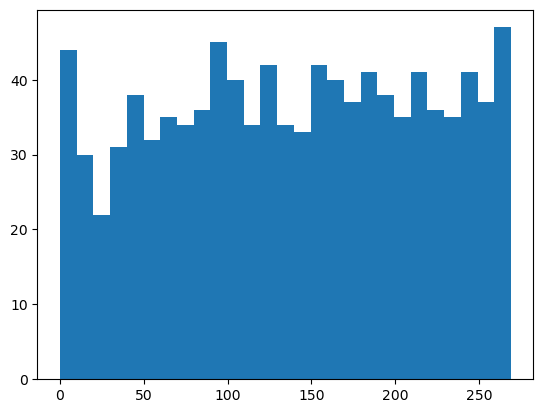

In [27]:
x = torch.randint(0, 270, (1000,)).float()
# x = (x - x.mean()) / x.std()
plt.hist(x, bins=27)

In [28]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    # mini batch
    idx = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    emb = C[Xtr[idx]]
    hpreact = emb.view(emb.shape[0], 30) @ W1 #+ b1
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
    # if i == 9:
    #     plt.hist((torch.tanh(hpreact[0, :].data)))
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
        
    h = torch.tanh(hpreact)
    # plt.plot(h.data)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[idx])
    for p in parameters:
        p.grad = None
    loss.backward()

    # lr = lrs[i]
    if i > 100000:
        lr = 0.01
    else :
        lr = 0.1

    for p in parameters:
        p.data -= p.grad * lr
    
    if i % 10000 == 0:
        print(i, '/', max_steps, 'loss:', loss.item())
    lossi.append(loss.item())
print(loss)

0 / 200000 loss: 3.3146886825561523
10000 / 200000 loss: 2.1984434127807617
20000 / 200000 loss: 2.3374552726745605
30000 / 200000 loss: 2.435884475708008
40000 / 200000 loss: 2.011928081512451
50000 / 200000 loss: 2.259471893310547
60000 / 200000 loss: 2.477499485015869
70000 / 200000 loss: 2.1020002365112305
80000 / 200000 loss: 2.2788119316101074
90000 / 200000 loss: 2.186206340789795
100000 / 200000 loss: 1.9473828077316284
110000 / 200000 loss: 2.3010759353637695
120000 / 200000 loss: 1.983335256576538
130000 / 200000 loss: 2.452256917953491
140000 / 200000 loss: 2.383953094482422
150000 / 200000 loss: 2.1989870071411133
160000 / 200000 loss: 1.9731444120407104
170000 / 200000 loss: 1.8669058084487915
180000 / 200000 loss: 1.997373104095459
190000 / 200000 loss: 1.8346697092056274
tensor(2.4314, grad_fn=<NllLossBackward0>)


torch.Size([32, 200])


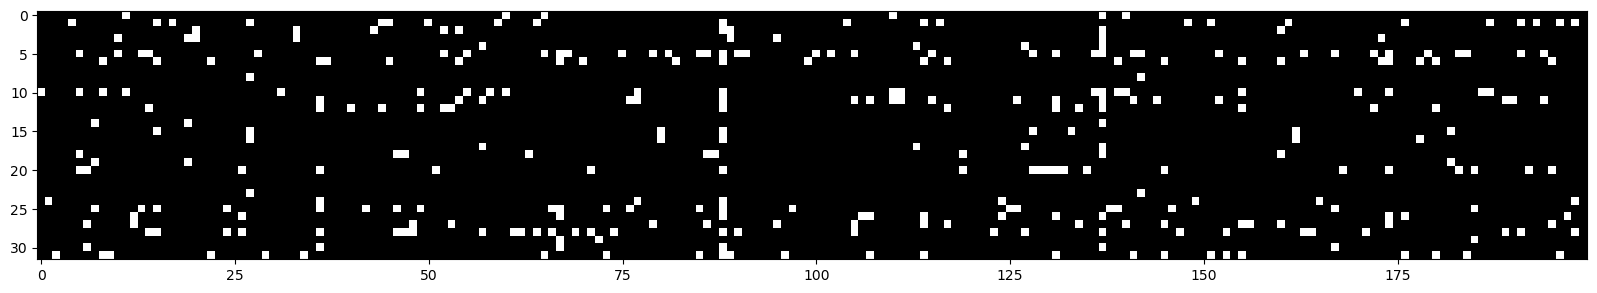

In [29]:
plt.figure(figsize=(20, 10))
print(h.shape)
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

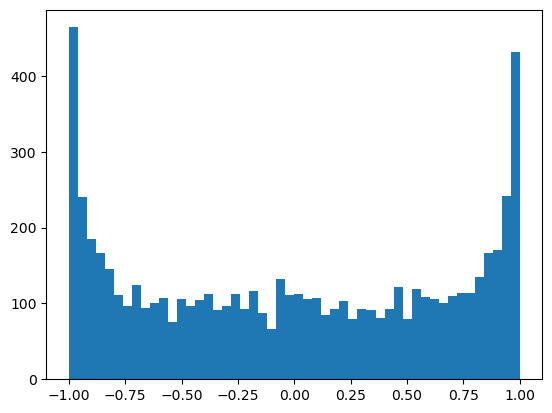

In [30]:
plt.hist(h.view(-1).detach().numpy(), bins=50);

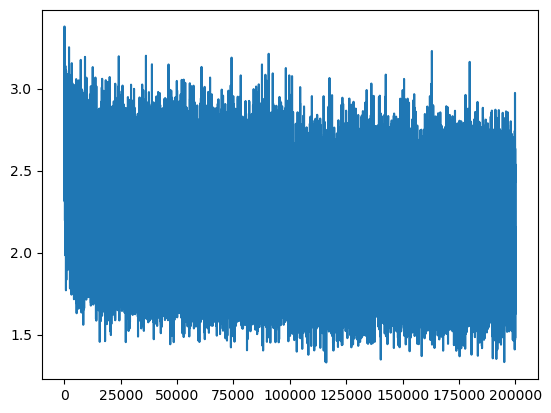

In [31]:
plt.plot(lossi)

In [33]:
print('mean:', bnmean_running)


mean: tensor([[-2.3745,  0.6784, -0.9000,  1.0357,  1.0875,  1.0954,  1.7348, -2.1460,
          0.5519,  1.4324, -1.6336, -2.7501, -0.4846, -0.1278, -0.0577, -1.1571,
          0.6884, -2.6514, -0.1424,  1.6363, -0.7775, -0.2741,  0.0533,  0.6089,
          1.1303,  0.2581,  2.0653,  0.5769,  0.8596,  1.7652, -0.3724, -0.8367,
         -0.0785, -0.5355, -0.3924, -1.0788, -0.0820,  0.3384, -0.5662,  1.0098,
         -0.4513, -1.3353, -0.2765, -0.2479,  0.6847,  0.6903,  2.0834, -0.7864,
          2.3891,  1.8486,  0.8083,  0.2642,  1.8708,  0.4746,  0.6552, -1.8984,
         -0.0301,  0.4480,  1.3996, -0.8739, -0.4680,  1.1599,  0.5481,  0.5931,
          1.5877,  1.2050, -1.0101,  2.1400, -0.6258,  0.1057, -0.2820, -0.4967,
          0.9521, -1.0195, -2.9917,  0.6157,  1.4418, -0.1616,  0.0961,  0.5138,
          0.2620,  1.2411,  1.9934,  0.6686,  0.0797, -0.0880, -1.6725,  0.2943,
          2.2242, -0.0040, -0.6448,  1.4457, -0.8407, -1.2340, -1.0124,  0.2130,
          0.1858, -0.3

In [35]:
emb = C[Xtr]
embcat = emb.view(emb.shape[0], -1)
hpreact = embcat @ W1
bnmean = hpreact.mean(0, keepdim=True)
bnstd = hpreact.std(0, keepdim=True)
print('mean:', bnmean)

mean: tensor([[-2.3560,  0.6687, -0.9132,  1.0361,  1.0847,  1.1030,  1.7396, -2.1311,
          0.5642,  1.4533, -1.6235, -2.7447, -0.4737, -0.1180, -0.0635, -1.1743,
          0.6845, -2.6334, -0.1206,  1.6448, -0.7749, -0.2939,  0.0545,  0.6085,
          1.1304,  0.2575,  2.0610,  0.5822,  0.8608,  1.7604, -0.3608, -0.8337,
         -0.0808, -0.5334, -0.3913, -1.0788, -0.0825,  0.3501, -0.5701,  1.0038,
         -0.4432, -1.3122, -0.2742, -0.2513,  0.6821,  0.6818,  2.0856, -0.7713,
          2.3952,  1.8606,  0.8225,  0.2711,  1.8803,  0.4750,  0.6635, -1.8962,
         -0.0282,  0.4462,  1.3832, -0.8743, -0.4527,  1.1665,  0.5555,  0.5982,
          1.5883,  1.2207, -1.0041,  2.1474, -0.6321,  0.0925, -0.2758, -0.4992,
          0.9647, -1.0513, -2.9982,  0.6280,  1.4341, -0.1632,  0.0947,  0.5232,
          0.2641,  1.2532,  2.0218,  0.6599,  0.0720, -0.0843, -1.6681,  0.2913,
          2.2291, -0.0150, -0.6445,  1.4353, -0.8388, -1.2271, -1.0032,  0.2160,
          0.2042, -0.3

In [23]:
@torch.no_grad()
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'dev': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, 'loss:', loss.item())

split_loss('train')
split_loss('dev')

train loss: 2.066826820373535
dev loss: 2.1048474311828613


In [ ]:
#  loss: log

'''
original
train: 2.1245
val 2.1682

fix softmax confidently wrong:
train: 2.07
val: 2.13

fix tanh layer too saturated at init:
train: 2.0356
val: 2.1027

use semi-principle "kaiming init" instead of hacky init:
train: 2.0376
val: 2.1682

add a batch norm layer
train: 2.0668
val: 2.1048
'''

In [117]:
# g = torch.Generator().manual_seed(2147483647)

def generate(n):
    for _ in range(n):
        context = [0] * block_size
        out = []
        while True:
            emb = C[torch.tensor([context])]
            embcat = emb.view(emb.shape[0], -1)
            hpreact = embcat @ W1
            hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
            h = torch.tanh(hpreact)
            logits = h @ W2 + b2
            p = F.softmax(logits, 1)
            ix = torch.multinomial(p, 1).item()
            if ix == 0:
                break
            out.append(ix)
            context = context[1:] + [ix]
            if len(out) == n:
                break
        print(''.join(itos[i] for i in out))
generate(20)
    

santhelah
demetrilo
vuel
laven
evaughna
eon
catoven
ron
mohsina
houren
angelona
keisinora
duri
akir
lynn
davitcherrewson
amison
jaylah
kelseila
madell


In [ ]:
# recreate pytorch class #

In [50]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.W = torch.randn((fan_in, fan_out)) / fan_in ** 0.5
        self.b = torch.randn(fan_out) if bias else None
        
    def __call__(self, x):
        self.out = x @ self.W
        if self.b is not None:
            self.out += self.b
        return self.out
    
    def parameters(self):
        return [self.W, self.b] if self.b is not None else [self.W]

In [51]:
class BatchNorm1d:

    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running mean and std)
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        if self.training:
            xmean = x.mean(0, keepdim=True)
            xvar = x.var(0, keepdim=True, unbiased=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / (xvar + self.eps).sqrt()
        self.out = self.gamma * xhat + self.beta

        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    
class Tanh:
    def __call__(self, x):
        self.out = x.tanh()
        return self.out
    def parameters(self):
        return []

In [54]:
n_embd = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)
vocab_size = 27

C = torch.randn((vocab_size, n_embd), generator=g)
layers = [
    Linear(n_embd * block_size, n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden),
    Tanh(),
    Linear(n_hidden, n_hidden),
    Tanh(),
    Linear(n_hidden, vocab_size),
]

with torch.no_grad():
    layers[-1].W *= 0.1

for layer in layers[:-1]:
    if isinstance(layer, Linear):
        layer.W *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

46497
